In [1]:
using LinearAlgebra, RowEchelon, Hadamard
using Random
using Latexify
using PyCall
itikz = pyimport("itikz")
nM    = pyimport("itikz.nicematrix")
jinja = pyimport("jinja2");

# 1.  Support Routines

## 1.1 LaTeX for Itikz

In [2]:
# To use itikz (a python library, we need to convert our numerical result to TeX strings)
function to_latex_str(x)
    if x < 0  # fix up minus signs
        replace( "-"*latexify(-x), "\$"=>"")
    else
        replace( latexify(x), "\$"=>"")
    end
end
# ------------------------------------------------------------------------------
function to_latex_str(x::Complex{Rational{Int64}})
    if imag(x) == 0
        return to_latex_str(real(x))
    end
    if real(x) < 0  # fix up minus signs
        replace( "-"*latexify(-x), "\$"=>"")
    else
        replace( latexify(x), "\$"=>"")
    end
end
# ------------------------------------------------------------------------------
function convert_to_latex(matrices)
    str_matrices = [[:none, to_latex_str.(matrices[1][2])]]
    for i in 2:size(matrices,1)
        push!( str_matrices, [ to_latex_str.(matrices[i][1]), to_latex_str.(matrices[i][2])] )
    end
    str_matrices
end;
# ------------------------------------------------------------------------------

## 1.2 Matrix Generation Routines

In [3]:
function factor_out_denominator( A::Array{Rational{Int64},2} )
    d = reduce( lcm, denominator.(A) )
    d, Int64.(d*A)
end

factor_out_denominator (generic function with 1 method)

In [4]:
PythagoreanNumberTriplets =
[   3    4    5
    5   12   13
    7   24   25
    8   15   17
    9   40   41
   11   60   61
   12   35   37
   13   84   85
   15  112  113 ]

PythagoreanNumberQuadruplets =
[   1   2   2   3
    2  10  11  15
    4  13  16  21
    2  10  25  27
    2   3   6   7
    1  12  12  17
    8  11  16  21
    2  14  23  27
    1   4   8   9
    8  9   12  17
    3  6   22  23
    7  14  22  27
    4   4   7   9
    1   6  18  19
    3  14  18  23
   10  10  23  27
    2   6   9  11
    6   6  17  19
    6  13  18  23
    3  16  24  29
    6   6   7  11
    6  10  15  19
    9  12  20  25
   11  12  24  29
    3   4  12  13
    4   5  20  21
   12  15  16  25
   12  16  21  29
    2   5  14  15
    4   8  19  21
    2   7  26  27 ];

In [5]:
function unit_lower(m,n; maxint=3)
    # create a unit lower triangular matrix
    [ x>y ? rand(-maxint:maxint) : (x == y ? 1 : 0) for x in 1:m, y in 1:n]
end
function unit_lower(m; maxint=3)
   unit_lower(m,m,maxint=maxint)
end
function lower(m,n; maxint=3)
    L = unit_lower(m,n; maxint=maxint)
    for i in 1:min(m,n)
        L[i,i] = rand( [-maxint:-1; 1:maxint])
    end
    L
end

function lower(m; maxint=3)
    lower(m,m,maxint=maxint)
end

function rref_matrix(m,n,r; maxint=3, pivot_in_first_col=true, has_zeros=false)
    # create a reduced row echelon form matrix of size m x n and rank r
    pivot_indices = sort!(randperm(n)[1:r])
    if pivot_in_first_col
        pivot_indices[1]= 1
    end
    if has_zeros
        rng = -mxint:maxint
    else
        rng = [-maxint:-1; 1:maxint]
    end

    if m > r
        M = [ rand(rng, (r,n))
              zeros(Int64, (m-r,n))
        ]
    else
        M = rand( rng, (m,n) )
    end
    for i in 1:r
        for j in 1:(pivot_indices[i]-1)
            M[i,j] = 0
        end
        M[i,pivot_indices[i]]         = 1
        M[1:(i-1), pivot_indices[i]] .= 0
    end
    M, pivot_indices
end
# ------------------------------------------------------------------------------
function symmetric_matrix(m;maxint=3, with_zeros=false )
    if with_zeros
        rng = -mxint:maxint
    else
        rng = [-maxint:-1; 1:maxint]
    end
    A = [ x>y ? rand(rng) : 0 for x in 1:m, y in 1:m]
    A = A+A'
    for i in 1:m
        A[i,i] = rand([-maxint:-1; 1:maxint])
    end
    A
end
# ------------------------------------------------------------------------------
function skew_symmetric_matrix(m;maxint=3, with_zeros=false )
    if with_zeros
        rng = -mxint:maxint
    else
        rng = [-maxint:-1; 1:maxint]
    end
    A = [ i>j ? rand(rng) : 0 for i in 1:m, j in 1:m]
    A - A'
end
# ------------------------------------------------------------------------------
function onecol(m,c; maxint=3)
    # take I and set column c to random entries
    E        = collect(1I(m))           # Int64  eye(m)
    E[1:m,c] = rand(-maxint:maxint, m)  # set column c to non-zero entries
    E[c,c]   = 1
    E
end
# ------------------------------------------------------------------------------
function W_2_matrix(;maxint=3)
    a,b,c = PythagoreanNumberTriplets[ rand(1:size(PythagoreanNumberTriplets,1)), : ]
    c,[ a -b; b a]
end
function Q_2_matrix(;maxint=3)
    c,W = W_2_matrix(maxint=maxint)
    W // c
end    
# ------------------------------------------------------------------------------
function W_3_matrix(;maxint=3)
    a,b,c = PythagoreanNumberTriplets[ rand(1:size(PythagoreanNumberTriplets,1)), : ]
    A = [ a -b 0
          b  a 0
          0  0 rand( [-maxint:-1; 1:maxint]) ]
    A = A[shuffle(1:3),:]
    c,A[ :, shuffle(1:3)]
end
# ------------------------------------------------------------------------------
function Q_3_matrix(;maxint=3)
    a,b,c = PythagoreanNumberTriplets[ rand(1:size(PythagoreanNumberTriplets,1)), : ]
    A = [ a//c -b//c  0
          b//c  a//c  0
             0     0  1 ]
    A = A[shuffle(1:3),:]
    A[ :, shuffle(1:3)]
end

# the following matrix has a block structure
function Q_4_blocks(;maxint=3)
    a1,b1,c1 = PythagoreanNumberTriplets[ rand(1:size(PythagoreanNumberTriplets,1)), : ]
    a2,b2,c2 = PythagoreanNumberTriplets[ rand(1:size(PythagoreanNumberTriplets,1)), : ]

    A = [ a1//c1 -b1//c1             0            0
          b1//c1  a1//c1             0            0
          0                          0   a2//c2  b2//c2 
          0                          0  -b2//c2  a2//c2 ]
    A = A[shuffle(1:4), :]
    A[ :, shuffle(1:4)]
end

function W_4_matrix(;maxint=3)
    a,b,c,d = PythagoreanNumberQuadruplets[ rand(1:size(PythagoreanNumberQuadruplets,1)), : ]
    p  = (a*a + b*b) * d*d
    a2 = -a*c* p
    a3 =  a*b* p
    a4 =  a*a* p

    den = gcd(gcd( a2, a3), a4 )
    a2 = Int64( a2 // den)
    a3 = Int64( a3 // den)
    a4 = Int64( a4 // den)

    A = [ a -b -c   0
          b  a  0  a2
          c  0  a  a3 
          0  c -b  a4 ]
    A = A
    A = A[shuffle(1:4), :]
    d,A[ :, shuffle(1:4)]
end

function Q_4_matrix(;maxint=3)
    d,W = W_4_matrix(maxint=maxint)
    W//d
end

function Q_matrix(n; maxint=3)
    if     n == 2 return Q_2_matrix(maxint=maxint)
    elseif n == 3 return Q_3_matrix(maxint=maxint)
    end
    S=skew_symmetric_matrix(n)
    A=inv(S-(1//1)I(size(S,1))) * (S+1I(size(S,1)))
end

function sparse_Q_matrix(n; maxint=3)
    sz = sum(n)
    A  = zeros(Rational{Int64},(sz,sz))
    i  = 1
    for m in n
        S = Rational{Int64}.( skew_symmetric_matrix(m) )
        E = (1//1)I(m)
        F = inv( S - E ) * ( S + E )
        rng = i:i+m-1 |> collect
        A[rng,rng] = F
        i += m
    end

    A = A[shuffle(1:sz), :]
    A[ :, shuffle(1:sz)]
end

function sparse_W(n; maxint=3)
    A = sparse_Q_matrix(n,maxint=maxint)
    factor_out_denominator(A)
end

sparse_W (generic function with 1 method)

In [6]:
function particular_solution( pivot_indices, n; maxint=3 )
    # given the pivot locations, generate a particular solution of N entries
    x                = zeros(Int64, (n,1))
    x[pivot_indices] = rand( [-maxint:-1; 1:maxint], (length(pivot_indices),1) )
    x
end

function eform(m,n; maxint=3, one_in_n=4, kill_a_row = 0)
    # create a row echelon form and a particular solution
    # TODO: fix for GJ; currently resulting in fractions  use gj_problem instead!!!
    sel = reshape( [-maxint:-1; 1:maxint], 2*maxint)
    U   = rand( sel, m,n)
    if kill_a_row > 0
        U[kill_a_row,1:n] .= 0
    end
    x = rand( sel, n)

    first = 1
    for i in 2:m
        have_p = rand( [Base.repeat([0], one_in_n-1); 1]) # whether this location has a pivot
        if have_p == 0 first = first+1 end
        first = min( first, n)
        x[first] = x[first]*have_p
        for j in 1:first U[i,j] = 0 end
        first = first+1
    end
    for j in (first+1):n x[j] = 0 end
    #
    U,x
end
# ------------------------------------------------------------------------------
function ge_pb(m,n; maxint=3, one_in_n=4)
    # create a GE problem sof size MxN, righthand side b and particular solution x
    e   = unit_lower(m,m,maxint=maxint)
    u,x = eform(m,n,maxint=maxint,one_in_n=one_in_n)
    A   = e*u
    b   = A*x
    A,x,b
end
# ------------------------------------------------------------------------------
function gj_problem(m,n,r; maxint=3, pivot_in_first_col=true)
    M,pivot_indices=rref_matrix(m,n,r,maxint=2,pivot_in_first_col=pivot_in_first_col)
    i = 1
    for j in pivot_indices
        M[i,j] = rand([-maxint:-1; 1:maxint])
        M[i,j+1:end] *= M[i,j]
        i += 1
    end

    A = unit_lower(m,maxint=maxint) * unit_lower(m,maxint=maxint)' * M
    x                = zeros(Int64, (n,1))
    x[pivot_indices] = rand( [-maxint:-1; 1:maxint], (r,1) )
    b = A*x
    A,x,b
end

function gj_problem(m,n; maxint=3, pivot_in_first_col=true)
    A,x,b = gj_problem(m,n,min(m,n), maxint=maxint, pivot_in_first_col=pivot_in_first_col)
end

function homogeneous_solutions( R, pivot_indices)
    # homogeneous solution from a reduced row echelon form R
    r = length(pivot_indices)                                                 # rank
    c = findall( j->j==1, [i in pivot_indices ? 0 : 1 for i in 1:size(R,2)] ) # free variable columns
    H = zeros(Int64, (size(R,2),length(c)))                                   # matrix of homogeneous solutions
    for j in eachindex( c )                                                   # homogeneous solution vector x_j
        H[c[j],j] = 1                                                         # set the current free variable entry to 1
        H[pivot_indices,j] = -R[1:r, c[j]]                                    # set the pivot variable values
    end
    H
end

# ------------------------------------------------------------------------------
function inv_pb(n; maxint=3)
    # create an invertible matix problem of size n x n
    e1 = unit_lower( n,n, maxint=maxint )
    e2 = unit_lower( n,n, maxint=maxint )
    A  = e1*e2'

    A_inv = inv(A)
    A, Int64.(round.(A_inv))
end
# ------------------------------------------------------------------------------
function print_np_array_def(A)
    M,N=size(A)
    println("A = np.array([")
    for i in 1:M
        print("[")
        for j in 1:(N-1)
            print(" ", A[i,j], ",")
        end
        println(" ", A[i, N], "],")
    end
    println("])")
end;

In [7]:
function plu_pb( m,n; maxint=3, one_in_n=4)
    # create a GE problem sof size MxN, righthand side b and particular solution x
    # TODO: if the last row happens to be zero, this may not work!
    e   = unit_lower(m,m,maxint=maxint)
    u,x = eform(m,n,maxint=maxint,one_in_n=one_in_n, kill_a_row=rand(2:m-1))
    A   = e*u
    b   = A*x
    A,x,b
end;

## 1.3 Gaussian Elimination Routine

In [8]:
function find_pivot(A, row, col)
    for i in row:size(A,1)
        if A[i,col] != 0  return i end
    end
    -1
end
function non_zero_entry( A, row, col, gj )
    set = (row+1):size(A,1)
    if gj && row > 1
        set = [1:row-1; set]
    end
    for i in set
        if  A[i,col] != 0 return true end
    end
    false
end
function interchange(A, row_1, row_2)
    for j in 1:size(A,2)
        A[row_1,j],A[row_2,j] = A[row_2,j],A[row_1,j]
    end
end
function eliminate( A, pivot_row, row, alpha)
    for j in 1:size(A,2)
        A[row,j] += alpha * A[pivot_row,j]
    end
end

function e_ref(A; gj=false)
    matrices       = [[ :none, A ]]
    pivot_indices  = []
    A              = copy(A)
    M,N            = size(A)
    row = 1; col = 1
    while true
        if (row > M) || (col > N)
            if gj && M > 0
                E = Matrix{Rational{Int64}}(I, M, M)
                for i in 1:size(pivot_indices,1)
                    E[i,i] = 1 // A[i,pivot_indices[i]] 
                end
                push!(matrices, [E, E*A])
            end
            return matrices, pivot_indices
        end

        p = find_pivot(A, row, col)
        if p < 0
            col += 1
        else
            push!(pivot_indices, col)
            if p != row
                interchange( A, p, row )
                E = Matrix{eltype(A)}(I, M, M)
                interchange( E, p, row )
                push!(matrices, [E, copy(A)])
            end

            if non_zero_entry( A, row, col, gj )
                E = Matrix{eltype(A)}(I, M, M)

                for r in (row+1):M
                    alpha = -A[r,col] / A[row,col]
                    eliminate(A, row, r, alpha )
                    eliminate(E, row, r, alpha )
                end

                if gj
                    for r in 1:(row-1)
                        alpha = -A[r,col] / A[row,col]
                        eliminate(A, row, r, alpha )
                        eliminate(E, row, r, alpha )
                    end
                end

                push!(matrices, [E, copy(A)])
            end
            col += 1; row += 1
        end
    end
end;

## 1.4 QR Routine

In [9]:
"""Naive Gram-Schmidt"""
function gram_schmidt_w(A)
    W   = Array{Rational{eltype(A)}}(undef, size(A))
    M,N = size(A)
    for j=1:N
        v_j = Rational.(A[:,j])
        for k=1:j-1
            v_j = v_j - (dot(W[:,k], A[:,j]) / dot(W[:,k], W[:,k]) ) .* W[:,k]
        end
        tmp = reduce( (x,y)-> lcm(x,denominator(y)), v_j, init=1) * v_j
        d   = reduce( gcd, tmp, init=tmp[1] )
        W[:,j] =  tmp / d
    end
    Int64.(W)
end

function qr_layout(A)
    W = gram_schmidt_w(A)

    WtW  = Diagonal(W'W)
    WtA  = W'A
    S    =  ((x-> Rational{Int64}(round(sqrt(x)))).(WtW))^(-1)

    Qt = S * W'
    R  = S * WtA

    matrices =  [ [ :none,  :none,     A,        W ],
                  [ :none,     W',   WtA,      WtW ],
                  [     S,     Qt,     R,    :none ] ]

    convert_to_latex( matrices )
end;

# 2. GE Problems

## 2.1 GE Problem with Layout

In [10]:
A,x,b = ge_pb(3,5)
display("*************************** A ="); display(A)
display("*************************** b ="); display(b)
display("*************************** x ="); display(x)
print_np_array_def( [A b])

"*************************** A ="

3×5 Array{Int64,2}:
 2  -3  -2   2   3
 2  -3   0  -1   2
 0   0   6  -9  -4

"*************************** b ="

3-element Array{Int64,1}:
  -1
  -4
 -10

"*************************** x ="

5-element Array{Int64,1}:
 -3
  0
 -1
  0
  1

A = np.array([
[ 2, -3, -2, 2, 3, -1],
[ 2, -3, 0, -1, 2, -4],
[ 0, 0, 6, -9, -4, -10],
])


Particular Solution: [4, 0, -2, 0, 3, 0]



Latexmk: Run number 1 of rule 'xelatex'
Latexmk: Run number 2 of rule 'xelatex'
Latexmk: Run number 1 of rule 'xdvipdfmx'


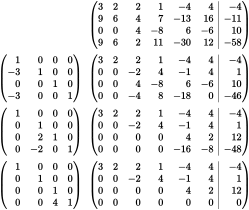

In [11]:
A,x,b = ge_pb( 4,6, maxint=4, one_in_n=4 )
matrices, pivot_indices = e_ref(Rational{Int64}.([A b]), gj=false)
#println("Matrix type information:", typeof(matrices[1][2]))
println("Particular Solution: ", x)
println()
h,m=nM.ge(convert_to_latex(matrices), formater=x->x, Nrhs=1)
h

Particular Solution: [-2, 0, 4, 0, -4, 0]



Latexmk: Run number 1 of rule 'xelatex'
Latexmk: Run number 2 of rule 'xelatex'
Latexmk: Run number 1 of rule 'xdvipdfmx'


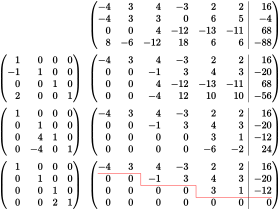

In [12]:
A,x,b = ge_pb( 4,6, maxint=4, one_in_n=4 )
matrices, pivot_indices = e_ref(Rational{Int64}.([A b]), gj=false)
#println("Matrix type information:", typeof(matrices[1][2]))
println("Particular Solution: ", x)
println()

pivot_locs = [(i-1,Int64(pivot_indices[i]-1)) for i in eachindex(pivot_indices)]

h,m = nM.ge(convert_to_latex(matrices), formater=x->x, Nrhs=1,
           ref_path_list =  [ [length(matrices)-1, 1, pivot_locs, "hh","red"] ])
h

"Homogeneous Solutions: "

6×3 Array{Int64,2}:
 -1  -1  -2
  1   0   0
  0   1   0
  0   0   1
  0   0  -1
  0   0   1

Particular Solution: [2; 0; 0; 4; -2; 0]
pivot list:          [1, 4, 5]




Latexmk: Run number 1 of rule 'xelatex'
Latexmk: Run number 2 of rule 'xelatex'
Latexmk: Run number 1 of rule 'xdvipdfmx'


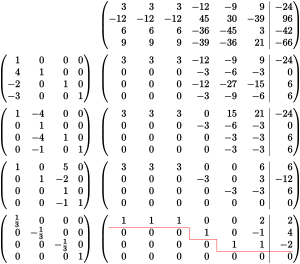

In [13]:
A,x,b=gj_problem(4,6,3, maxint=4 )
matrices, pivot_indices = e_ref(Rational{Int64}.([A b]), gj=true)

println("Particular Solution: ", x)
println("pivot list:          ", Int64.(pivot_indices) )
println()
# -------------------------------------------------------------------
R = matrices[length(matrices)][2]
R=R[:,1:size(A,2)]

H = homogeneous_solutions( R, pivot_indices )
display("Homogeneous Solutions: "); display(H)
println()
# -------------------------------------------------------------------
pivot_locs = [(i-1,Int64(pivot_indices[i]-1)) for i in eachindex(pivot_indices)]

h,m=nM.ge( convert_to_latex(matrices), formater=x->x, Nrhs=1,
           ref_path_list =  [ [length(matrices)-1, 1, pivot_locs, "hh","red"] ]
)
h

In [14]:
R = matrices[length(matrices)][2]
R=R[:,1:size(A,2)]

println( "Homogeneous Solutions")
H = homogeneous_solutions( R, pivot_indices )

Homogeneous Solutions


6×3 Array{Int64,2}:
 -1  -1  -2
  1   0   0
  0   1   0
  0   0   1
  0   0  -1
  0   0   1

## 2.2 Inverse Problem with Layout

In [15]:
A, A_inv = inv_pb(3, maxint=4)
display("A ="); display(A)
display("A.inv ="); display(A_inv)

print_np_array_def([A I(size(A)[1]) ])

"A ="

3×3 Array{Int64,2}:
  1  0  -2
 -1  1   3
 -1  2   5

"A.inv ="

3×3 Array{Int64,2}:
 -1  -4   2
  2   3  -1
 -1  -2   1

A = np.array([
[ 1, 0, -2, 1, 0, 0],
[ -1, 1, 3, 0, 1, 0],
[ -1, 2, 5, 0, 0, 1],
])


Latexmk: Run number 1 of rule 'xelatex'
Latexmk: Run number 2 of rule 'xelatex'
Latexmk: Run number 1 of rule 'xdvipdfmx'


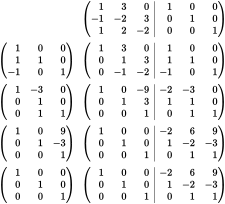

In [16]:
A, A_inv               = inv_pb(3, maxint=4)
matrices,pivot_indices = e_ref(Rational{Int64}.([A 1I]), gj=true)
h,m=nM.ge( convert_to_latex(matrices), formater=x->x, Nrhs=size(A,1) )
h

## 2.3 PLU Problem

Latexmk: Run number 1 of rule 'xelatex'
Latexmk: Run number 2 of rule 'xelatex'
Latexmk: Run number 1 of rule 'xdvipdfmx'


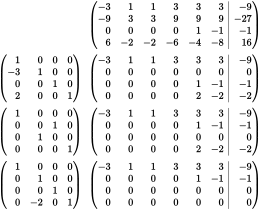

In [17]:
A,x,b=plu_pb(4,6)
matrices,pivot_indices = e_ref([A b])
h,m=nM.ge(convert_to_latex(matrices), formater=x->x, Nrhs=1 )
h

# 3 Normal Equation Problems

<strong style="color:red;">needs work...</strong>

## 3.1 Solve the Normal Equation

In [18]:
function normal_equation_matrix(m,n; maxint=3)
    Q = sparse_Q_matrix(m,maxint=maxint)
    m = sum(m)
    n = sum(n)
    M = zeros(Int64, (m,n))
    for i = 1:min(m,n)
        M[i,i] = rand( [-maxint:-1; 1:maxint])
    end
    Q[:,1:m]*unit_lower(m,maxint=maxint)*M
end

A=normal_equation_matrix((3,2),2)
d,intA = factor_out_denominator(A)
println( "A = ", 1//d, " [");
for i in 1:size(A,1)
    for j in 1:size(A,2)
        print("\t", intA[i,j] )
    end
    println()
end
println("]")
Int64.(inv(A'A)*det(A'A))

A = 1//35 [
	-80	-135
	-14	56
	-30	-55
	-50	-45
	98	-42
]


2×2 Array{Int64,2}:
 23  -8
 -8  16

In [19]:
function ca_projection_matrix(A)
    A*inv(A'A)*A'
end
P=ca_projection_matrix( normal_equation_matrix(4,1))
d,intP = factor_out_denominator(P)
display( 1//d);display(intP);

1//8750

4×4 Array{Int64,2}:
   25  -460    30   -75
 -460  8464  -552  1380
   30  -552    36   -90
  -75  1380   -90   225

# 4. QR Problems

## 4.1 Orthogonal Matrices

In [20]:
function qr_problem(even_n;maxint=3)
    hadamard(even_n)[:,shuffle(1:even_n)]*lower(even_n,maxint=maxint)'
end

function qr_problem_3(;maxint=3)
    d,W = W_3_matrix(maxint=maxint)
    W*unit_lower(3, maxint=maxint)'
end

function qr_problem_4(;maxint=3)
    d,W = W_4_matrix(maxint=maxint)
    W*unit_lower(4,maxint=maxint)'
end
;

In [21]:
S = Q_matrix(4); display(S)
Int64.(S'S)

4×4 Array{Rational{Int64},2}:
 -5//23  -20//23    2//23  10//23
  2//23    8//23  -10//23  19//23
 22//23   -4//23    5//23   2//23
 -4//23    7//23   20//23   8//23

4×4 Array{Int64,2}:
 1  0  0  0
 0  1  0  0
 0  0  1  0
 0  0  0  1

## 4.2 QR

Latexmk: Run number 1 of rule 'xelatex'
Latexmk: Run number 2 of rule 'xelatex'
Latexmk: Run number 1 of rule 'xdvipdfmx'


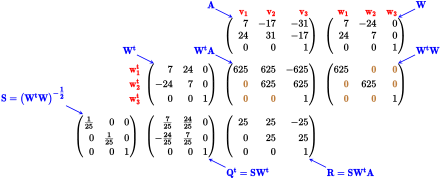

In [22]:
A   = qr_problem_3(maxint=1)
W   = gram_schmidt_w(A)
h,m = nM.gram_schmidt_qr(A, W)
h

Latexmk: Run number 1 of rule 'xelatex'
Latexmk: Run number 2 of rule 'xelatex'
Latexmk: Run number 1 of rule 'xdvipdfmx'


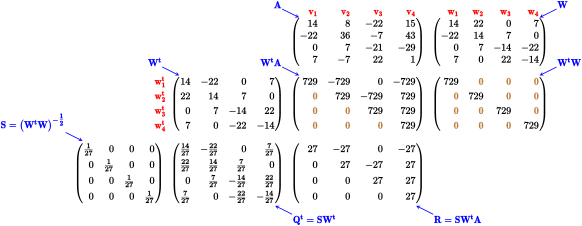

In [23]:
A   = qr_problem_4(maxint=1)
W   = gram_schmidt_w(A)
h,m = nM.gram_schmidt_qr(A, W)
h

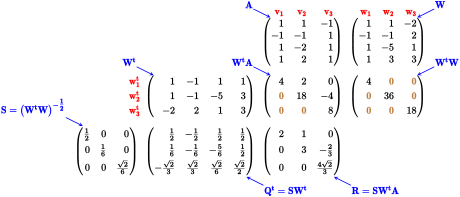

In [24]:
A=[ 1  1 -1
   -1 -1  1
    1 -2  1
    1  2  1
]
W   = gram_schmidt_w(A)
h,m = nM.gram_schmidt_qr(A, W)
h

Latexmk: Run number 1 of rule 'xelatex'
Latexmk: Run number 2 of rule 'xelatex'
Latexmk: Run number 1 of rule 'xdvipdfmx'


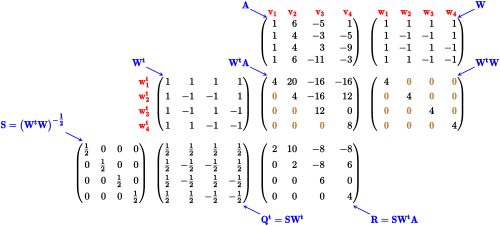

In [25]:
A   = qr_problem(4, maxint=5) #[:,shuffle(2:4)]
W   = gram_schmidt_w(A)
h,m = nM.gram_schmidt_qr(A, W)
h

# 5. Eigenproblems

In [26]:
function eigenproblem( e_vals; maxint=3 )
    Λ = Diagonal( e_vals )
    S,S_inv = inv_pb( size(e_vals,1), maxint=maxint )
    S*Λ*S_inv
end
function symmetric_eigenproblem( e_vals; maxint=3 )
    S = Q_matrix( size(e_vals,1), maxint=maxint )
    S * Diagonal( e_vals ) * S'
end
function non_diagonalizable_eigenproblem( e_dup, e; maxint=4 )
    S,S_inv = inv_pb(3, maxint=maxint )
    Λ = [e_dup 1 0; 0 e_dup 0; 0 0 e]
    S * Λ * S_inv
end

function svd_problem(m,n,σ; maxint = 3)
    U  = sparse_Q_matrix( m, maxint=maxint)
    Vt = sparse_Q_matrix( n, maxint=maxint)
    m = sum(m); n=sum(n)
    Σ  = zeros(eltype(σ[1]), m,n)
    for i in 1:min( m, size(σ,1) )
        Σ[i,i] = σ[i]
    end
    U * Σ * Vt
end
;

In [27]:
A=eigenproblem([0,2,0])

3×3 Array{Int64,2}:
  0    0   0
  4    6   2
 -8  -12  -4

In [28]:
A=symmetric_eigenproblem([1,1,0], maxint=2)

3×3 Array{Rational{Int64},2}:
   9//25  -12//25  0//1
 -12//25   16//25  0//1
   0//1     0//1   1//1

In [29]:
A=non_diagonalizable_eigenproblem( 0,2)

3×3 Array{Int64,2}:
  46   -6   -7
  96  -12  -15
 212  -28  -32

In [30]:
A=svd_problem( 3,[3,2],  [2,2],  maxint=2)

3×5 Array{Rational{Int64},2}:
  90//161  0//1  -132//161  0//1   264//161
 -12//161  0//1  -240//161  0//1  -164//161
  24//161  0//1  -164//161  0//1     6//161

In [31]:
svd(A)

SVD{Float64,Float64,Array{Float64,2}}
U factor:
3×3 Array{Float64,2}:
 -0.958315   4.07656e-17  -0.285714
  0.127775  -0.894427     -0.428571
 -0.255551  -0.447214      0.857143
singular values:
3-element Array{Float64,1}:
 2.0000000000000004
 2.0
 7.679839108964491e-17
Vt factor:
3×5 Array{Float64,2}:
 -0.291661      0.0           0.42777    0.0  -0.855539
 -1.19194e-16  -9.93014e-17   0.894427   0.0   0.447214
 -0.42777      -0.894427     -0.0583322  0.0   0.116664

In [32]:
#A=svd_problem(4,[2,3],[2,1,1])
A= 125A

3×5 Array{Rational{Int64},2}:
 11250//161  0//1  -16500//161  0//1   33000//161
 -1500//161  0//1  -30000//161  0//1  -20500//161
  3000//161  0//1  -20500//161  0//1     750//161

# Stuff

In [33]:
A = [ 66.  -88  -66    20  88
      60   -80   15   -50 -20
      12   -16  -12  -110  16
     120  -160   30    25  -40 ]/125
println(eigvals( A'A  ))
println(eigvals( A*A' ))
A*A'

[2.6971493175987273e-17, 2.7755575615628914e-17, 0.9999999999999986, 1.0, 4.0]
[-1.5803053019385431e-16, 0.9999999999999997, 1.0, 3.9999999999999987]


4×4 Array{Float64,2}:
 1.5744  0.464  0.1408  1.088
 0.464   0.84   0.448   1.28
 0.1408  0.448  0.8256  0.016
 1.088   1.28   0.016   2.76

In [34]:
V = round.(eigvecs(A'A), digits=3)

5×5 Array{Float64,2}:
  0.8   0.0  -0.0   0.0   0.6
  0.6   0.0   0.0   0.0  -0.8
  0.0  -0.8   0.0  -0.6  -0.0
 -0.0   0.0  -1.0   0.0  -0.0
  0.0  -0.6   0.0   0.8   0.0

In [35]:
U = round.(eigvecs(A*A'), digits=4)

4×4 Array{Float64,2}:
 -0.08   0.7155   0.5367  -0.44
 -0.8    0.0     -0.4472  -0.4
  0.44   0.5367  -0.7155  -0.08
  0.4   -0.4472   0.0     -0.8

In [36]:
AV=round.(A*V, digits=3)
norm(AV[:,5])

2.0

In [37]:
round.(eigvals(A'A))

5-element Array{Float64,1}:
 0.0
 0.0
 1.0
 1.0
 4.0

In [38]:
S=skew_symmetric_matrix(7,maxint=1)

7×7 Array{Int64,2}:
  0   1  -1  -1  -1  -1   1
 -1   0   1   1  -1  -1  -1
  1  -1   0   1  -1   1  -1
  1  -1  -1   0   1  -1   1
  1   1   1  -1   0  -1   1
  1   1  -1   1   1   0   1
 -1   1   1  -1  -1  -1   0

In [39]:
A = Q_matrix(7,maxint=1)

7×7 Array{Rational{Int64},2}:
   355//551     -168//551     -100//551    …   -10//29     -30//551
 -2746//12673   7092//12673  -5854//12673     -104//667  -4401//12673
 -4672//12673   -856//12673   8805//12673       -4//667  -2042//12673
 -2952//12673   3452//12673  -2878//12673       66//667   1010//12673
 -4200//12673  -5804//12673  -1828//12673     -264//667  -8042//12673
  1582//12673  -3052//12673  -2184//12673  …   553//667  -5504//12673
 -5976//12673  -6303//12673  -5208//12673       36//667   6372//12673

In [40]:
d,F=sparse_W([3,3])
println("Common Denominator: ", d)
display(F)
println( "W'W diagonal:      ", diag(F'F)' )

6×6 Array{Int64,2}:
   5  -14    2    0   0    0
   0    0    0  -10  10    5
 -10   -2   11    0   0    0
 -10   -5  -10    0   0    0
   0    0    0   -5   2  -14
   0    0    0   10  11   -2

Common Denominator: 15
W'W diagonal:      [225 225 225 225 225 225]


In [71]:
A=svd_problem(3,[2,3],[2,2,1])

3×5 Array{Rational{Int64},2}:
   -6//115  0//1  -48//115    36//115  -158//115
 -164//115  0//1  -24//115    18//115  -102//115
  -24//115  0//1  176//115  -132//115   -57//115

In [13]:
A=[   -6  0  -48    36  -158
 -164  0  -24    18  -102
  -24  0  176  -132   -57]/115
Int64.(115A)

3×5 Array{Int64,2}:
   -6  0  -48    36  -158
 -164  0  -24    18  -102
  -24  0  176  -132   -57

In [88]:
print(latexify(Int64.(115A)))

\begin{equation}
\left[
\begin{array}{ccccc}
-6 & 0 & -48 & 36 & -158 \\
-164 & 0 & -24 & 18 & -102 \\
-24 & 0 & 176 & -132 & -57 \\
\end{array}
\right]
\end{equation}


In [83]:
print(latexify(Int64.(529A*A')))

\begin{equation}
\left[
\begin{array}{ccc}
1144 & 756 & -162 \\
756 & 1528 & 126 \\
-162 & 126 & 2089 \\
\end{array}
\right]
\end{equation}


In [93]:
print(latexify(Int64.(25A'A)))

\begin{equation}
\left[
\begin{array}{ccccc}
52 & 0 & 0 & 0 & 36 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 64 & -48 & 0 \\
0 & 0 & -48 & 36 & 0 \\
36 & 0 & 0 & 0 & 73 \\
\end{array}
\right]
\end{equation}


In [3]:
round.(eigvals(A'A))

5-element Array{Float64,1}:
 0.0
 0.0
 1.0
 4.0
 4.0

In [14]:
V=Int64.(round.(-10*eigvecs(A'A), digits=0))

5×5 Array{Int64,2}:
  0   0   8  -6   0
 10   0   0   0   0
  0  -6   0   0  -8
  0  -8   0   0   6
  0   0  -6  -8   0

In [5]:
print(latexify(V[:,[5,4,3,2,1]]))

\begin{equation}
\left[
\begin{array}{ccccc}
0 & -6 & 8 & 0 & 0 \\
0 & 0 & 0 & 0 & 10 \\
-8 & 0 & 0 & -6 & 0 \\
6 & 0 & 0 & -8 & 0 \\
0 & -8 & -6 & 0 & 0 \\
\end{array}
\right]
\end{equation}


In [6]:
print(latexify(diagm([4,1,1,0,0])))

\begin{equation}
\left[
\begin{array}{ccccc}
4 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
\end{array}
\right]
\end{equation}


In [22]:
U_r=A*V[:,[5,4,3]]*diagm([1/2,1/2,1])/10
print(latexify(round.(U_r,digits=2)))
round.(U_r'U_r)

\begin{equation}
\left[
\begin{array}{ccc}
0.26 & 0.57 & 0.78 \\
0.13 & 0.78 & -0.61 \\
-0.96 & 0.26 & 0.13 \\
\end{array}
\right]
\end{equation}


3×3 Array{Float64,2}:
  1.0  0.0  -0.0
  0.0  1.0   0.0
 -0.0  0.0   1.0

In [23]:
eigvals(A*A')

3-element Array{Float64,1}:
 0.9999999999999999
 4.0
 4.000000000000001